# Определение перспективного тарифа для телеком-компании

Клиентам компании «Мегалайн» предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
В рамках данного проекта, предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

In [1]:
import pandas as pd
import math
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

pd.set_option('display.float_format', '{:,.2f}'.format)

## Открытие файлов с данными и изучение общей информации

### Таблица "Звонки"

In [2]:
# Загрузка и первый взгляд, проверка дубликатов
df_calls = pd.read_csv('/datasets/calls.csv', parse_dates=['call_date'])
df_calls.info()
print('Дубликатов', df_calls.duplicated().sum())
display(df_calls.head())
df_calls.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB
Дубликатов 0


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,duration,user_id
count,"202,607.00","202,607.00"
mean,6.76,"1,253.94"
std,5.84,144.72
min,0.00,"1,000.00"
25%,1.30,"1,126.00"
50%,6.00,"1,260.00"
75%,10.70,"1,379.00"
max,38.00,"1,499.00"


### Таблица "Интернет-сессии"

In [3]:
# Загрузка и первый взгляд, проверка дубликатов
df_internet = pd.read_csv('/datasets/internet.csv', parse_dates=['session_date'], index_col='Unnamed: 0')
df_internet.info()
print('Дубликатов', df_internet.duplicated().sum())
display(df_internet.describe())
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB
Дубликатов 0


,mb_used,user_id
count,"149,396.00","149,396.00"
mean,370.19,"1,252.10"
std,278.30,144.05
min,0.00,"1,000.00"
25%,138.19,"1,130.00"
50%,348.01,"1,251.00"
75%,559.55,"1,380.00"
max,"1,724.83","1,499.00"


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,"1,052.81",2018-09-07,1000
2,1000_2,"1,197.26",2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


### Таблица "Сообщения"

In [4]:
# Загрузка и первый взгляд, проверка дубликатов
df_messages = pd.read_csv('/datasets/messages.csv', parse_dates=['message_date'])
df_messages.info()
print('Дубликатов', df_messages.duplicated().sum())
df_messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB
Дубликатов 0


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


### Таблица "Тарифы"

In [5]:
# Загрузка и первый взгляд
df_tarif  = pd.read_csv('/datasets/tariffs.csv', index_col='tariff_name')
df_tarif.info()
df_tarif

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, smart to ultra
Data columns (total 7 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
dtypes: int64(7)
memory usage: 128.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
tariff_name,,,,,,,
smart,50,15360,500,550,200,3,3
ultra,1000,30720,3000,1950,150,1,1


### Таблица "Пользователи"

In [6]:
# Загрузка и первый взгляд, проверка дубликатов
df_users = pd.read_csv('/datasets/users.csv', parse_dates=['reg_date', 'churn_date'], index_col='user_id')
df_users.info()
print('Дубликатов', df_users.duplicated().sum())
display(df_users.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1000 to 1499
Data columns (total 7 columns):
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 31.2+ KB
Дубликатов 0


,age,churn_date,city,first_name,last_name,reg_date,tariff
user_id,,,,,,,
1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


**Вывод**

На этапе загрузки данных из файлов, осуществили преобразование колонок содержащих дату в тип datetime64. В таблице internet колонку с индексами 'Unnamed: 0' указали как содержащую индексы. Таким же образом, в таблице тарифов, колонку tariff сделали индексом. Это поможет в дальнейшей обработке данных. Остальные типы данных не нуждаются в преобразованиях. 
Пропусков нет кроме колонки churn_date	таблицы users. Это означает, что пользователи с NaN в данной колонке не меняли тариф. Поэтому избавлятся от пропусков в этой колонке не имеет смысла.
Дубликаты в данных отсутствуют.

## Подготовка данных

### Приведение данных к нужным типам

На этапе загрузки таблиц из файлов было произведено приведение к типу datetime64 колонок содержащих дату. Остальные типы данных соответствуют содержанию и не требуют преобразования. 

В данном разделе, в соответствии с правилами тарификации, произведём округление продолжительности звонков в большую сторону. Также, для простоты дальнейшего анализа добавим с таблицы df_calls, df_internet и df_messages колонки со значением месяца.

In [7]:
# Округление продолжительности звонка в большую сторону
df_calls['duration'] = df_calls['duration'].apply(math.ceil)
# Добавляем колонку месяц
df_calls['month']    = df_calls['call_date'].dt.month
df_internet['month'] = df_internet['session_date'].dt.month
df_messages['month'] = df_messages['message_date'].dt.month

### Поиск и исправление ошибок в данных.

В данных были обнаружены звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять. Также были обнаружены интернет сессии нулевого объёма. Скорее всего, это так же ошибкой не является.

### Расчёты для каждого пользователя:

Произведём расчёт для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя 

Для расчёта помесячной выручки необходимо:
- вчесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; 
- остаток умножить на значение из тарифного плана;
- прибавить абонентскую плату, соответствующую тарифному плану.

In [8]:
def calc_expenses(row):
    # Функция для расчёта месячной платы
    #tarif = df_users.loc[row.name[0],'tariff'] #имя тарифа из табл users по user_id по row
    tarif = row['tariff']
    # Абонентская плата
    pay_month = df_tarif.loc[tarif, 'rub_monthly_fee']
    # Плата за звонки сверх лимита
    if  row['duration_min'] > df_tarif.loc[tarif, 'minutes_included']: 
        pay_month += (row['duration_min'] - df_tarif.loc[tarif, 'minutes_included']) * df_tarif.loc[tarif, 'rub_per_minute']
    # Плата за сообщения сверх лимита
    if  row['message'] > df_tarif.loc[tarif, 'messages_included']: 
        pay_month += (row['message'] - df_tarif.loc[tarif, 'messages_included']) * df_tarif.loc[tarif, 'rub_per_message']
    # Плата за интернет сверх лимита
    if  row['mb_used'] > df_tarif.loc[tarif, 'mb_per_month_included']: 
        pay_month += math.ceil((row['mb_used'] - df_tarif.loc[tarif, 'mb_per_month_included'])/1024) * df_tarif.loc[tarif, 'rub_per_gb']
    return pay_month

In [9]:
# Создадим таблицу с информацией о израсходованном кол-ве звонков, 
# сообщений и интернета для каждого пользователя по месяцам
# Начинаем со сводной таблице звонков
df_expenses = df_calls.pivot_table(index=['user_id','month'], 
                                  values='duration', 
                                 aggfunc=['sum','count'])
# Добавим к сводной таблице по звонкам сводную таблицу с информацией о интернет трафике
df_expenses = df_expenses.merge(df_internet.pivot_table(index=['user_id','month'], 
                                                       values='mb_used', 
                                                      aggfunc='sum'),
                               on =['user_id','month'], how='left')
# Добавим к сводной таблице сводную таблицу с информацией о количестве сообщений
df_expenses = df_expenses.merge(df_messages.pivot_table(index=['user_id','month'], 
                                                       values='id', 
                                                      aggfunc='count'),
                               on=['user_id','month'], how='left')
# Добавим к таблице информацию о тарифах
df_expenses = df_expenses.join(df_users[['tariff', 'city']], on =['user_id'], how='left')

# Замена пропусков на нули
df_expenses = df_expenses.fillna(0)
# Добавим в таблицу данные по расходу трафика в гигабайтах
df_expenses['gb_used'] = (df_expenses['mb_used']/1024).apply(math.ceil)
# Переименование колонок
df_expenses = df_expenses.rename(columns={('sum', 'duration'): 'duration_min',
                                          ('count', 'duration'): 'duration_count',
                                          'id': 'message'} )
# Расчёт ежемесячных трат для каждой строки в таблице с помощью выше созданной функции
df_expenses['month_pay'] = df_expenses.apply(calc_expenses, axis=1)

df_expenses.head(10)

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


duration_min  duration_count   mb_used  message tariff  \
user_id month                                                           
1000    5               159              22  2,253.49    22.00  ultra   
        6               172              43 23,233.77    60.00  ultra   
        7               340              47 14,003.64    75.00  ultra   
        8               408              52 14,055.93    81.00  ultra   
        9               466              58 14,568.91    57.00  ultra   
        10              350              57 14,702.49    73.00  ultra   
        11              338              43 14,756.47    58.00  ultra   
        12              333              46  9,817.61    70.00  ultra   
1001    11              430              59 18,429.34     0.00  smart   
        12              414              63 14,036.66     0.00  smart   

                    city  gb_used  month_pay  
user_id month                                 
1000    5      Краснодар        3   1,950.00  
        6      Краснодар       23   1,950.00  
        7      Краснодар       14   1,950.00  
        8      Краснодар       14   1,950.00  
        9      Краснодар       15   1,950.00  
        10     Краснодар       15   1,950.00  
        11     Краснодар       15   1,950.00  
        12     Краснодар       10   1,950.00  
1001    11        Москва       18   1,150.00  
        12        Москва       14     550.00

In [10]:
df_expenses.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3174 entries, (1000, 5) to (1499, 12)
Data columns (total 8 columns):
duration_min      3174 non-null int64
duration_count    3174 non-null int64
mb_used           3174 non-null float64
message           3174 non-null float64
tariff            3174 non-null object
city              3174 non-null object
gb_used           3174 non-null int64
month_pay         3174 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 211.7+ KB


**Вывод**

В данном разделе, произведн расчёт для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя

Свели расчёты и некоторые необходимые данные в отдельный датафрейм для дальнейшего анализа.

## Анализ данных

Опишем поведение клиентов оператора, исходя из выборки. 
Произведём расчёт, сколько требуется пользователям каждого тарифа в месяц:
- минут разговора,
- сообщений 
- объём интернет-трафика.

Для каждого параметра рассчитаем:
- среднее количество, 
- дисперсю,
- стандартное отклонение. 

Пострим гистограммы. Опишем распределения.

In [11]:
# Так как мы будем часто обращаться к выборкам по тарифам, выделим их в отдельные таблицы
df_smart = df_expenses[df_expenses['tariff'] == 'smart']
df_ultra = df_expenses[df_expenses['tariff'] == 'ultra']

def distrib(feature,title_name, x_label):
    # Функция для расчёта и вывода на экран распределения, среднего, дисерсии и ст. откл
    
    # Построение гистограмм    
    ax = df_smart.plot( y    =feature,
                        kind ='hist',
                        color='blue',
                        alpha=0.7,
                        label='Smart',
                        bins =50)
    ax.set_xlabel(x_label)
    (df_ultra.plot( y      =feature,
                    ax     =ax,
                    kind   ='hist',
                    color  ='green',
                    alpha  =0.7,
                    label  ='Ultra',
                    title  =title_name,
                    bins   =50,
                    figsize=(15,7)))
    plt.show()
    
    # Расчт среднего, дисперсии и стандартного отклонения
    distrib_tabl = df_expenses[['tariff', feature]].groupby('tariff').agg(['mean', 'var', 'std' ])
    distrib_tabl = distrib_tabl.rename(columns={'mean': 'Среднее',
                                                 'var': 'Дисперсия',
                                                 'std': 'Стандартное отклонение',
                                               feature: 'Показатели распределения'} )
    
    display(distrib_tabl)

### Распределение количества минут разговора в месяц

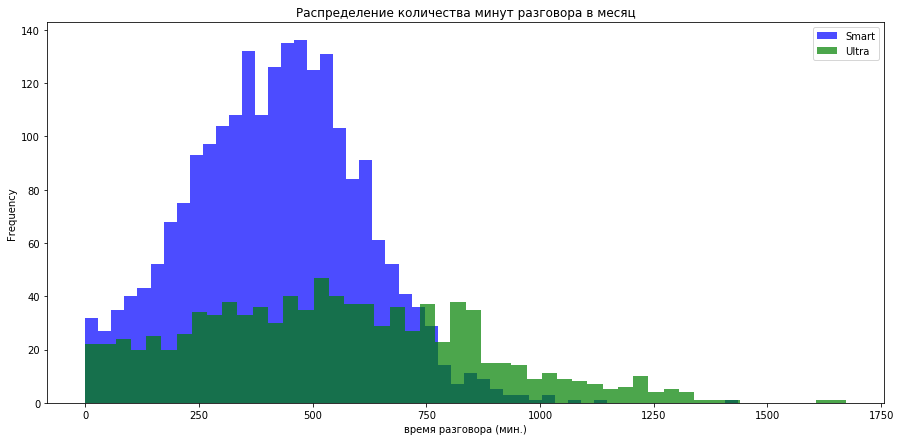

Показатели распределения                                 
                        Среднее Дисперсия Стандартное отклонение
tariff                                                          
smart                    419.06 35,844.19                 189.33
ultra                    545.45 94,203.42                 306.93

In [12]:
distrib('duration_min', 'Распределение количества минут разговора в месяц', 'время разговора (мин.)')

Пользователям тарифа Smart, в среднем, требуется 419 минут разговора в месяц. Большенство пользователей данного тарифа тратят от  230 до 608 минут. 

Пользователям тарифа Ultra, в среднем, требуется 545 минут разговора в месяц. Большенство пользователей данного тарифа тратят от  238 до 852 минут. 

Из анализа гистограмм распределения, дисперсии и стандартного отклонения, можно сделать вывод о том, что количество израсходованных минут пользователями тарифа Smart гораздо меньшее отклонено от среднего чем у пользователей тарифа Ultra.

### Распределение количества сообщений в месяц

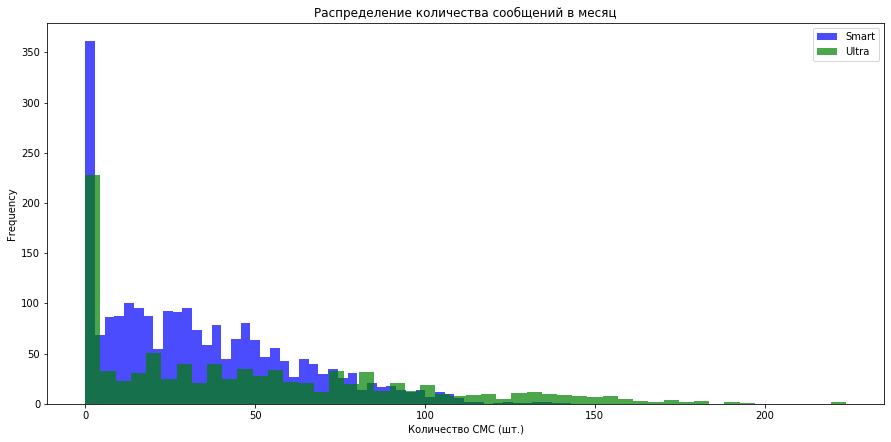

Показатели распределения                                 
                        Среднее Дисперсия Стандартное отклонение
tariff                                                          
smart                     33.40    798.60                  28.26
ultra                     49.03  2,198.73                  46.89

In [13]:
distrib('message', 'Распределение количества сообщений в месяц', 'Количество СМС (шт.)')

Пользователям тарифа Smart, в среднем, требуется 28 сообщений в месяц. Большенство пользователей данного тарифа используют от 5 до 61 сообщения в месяц. 

Пользователям тарифа Ultra, в среднем, требуется 49 сообщений. Большенство пользователей данного тарифа тратят от 3 до 96 сообщений. 

На гистограмме распределения видно, что большое количество пользователей обоих тарифов либо вовсе не используют СМС сообщения, либо используют не более 3-х в месяц.

### Распределение количества интернет трафика в месяц

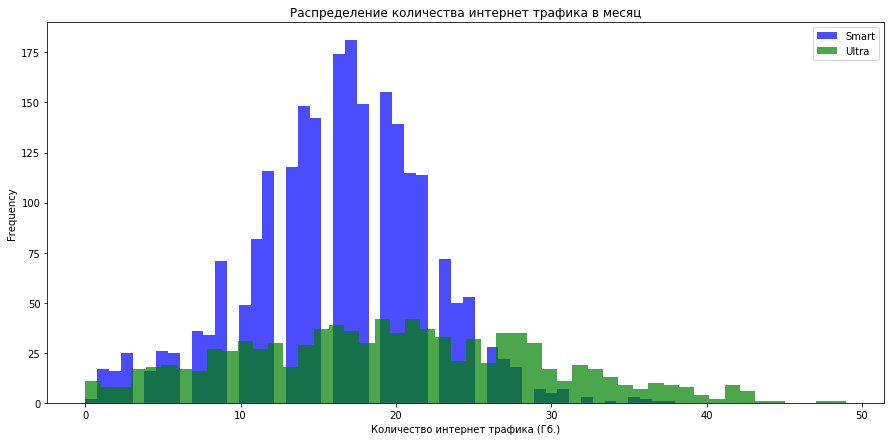

Показатели распределения                                 
                        Среднее Дисперсия Стандартное отклонение
tariff                                                          
smart                     16.33     33.09                   5.75
ultra                     19.49     97.82                   9.89

In [14]:
distrib('gb_used', 'Распределение количества интернет трафика в месяц', 'Количество интернет трафика (Гб.)')

Пользователям тарифа Smart, в среднем, требуется 16 Гб интернет трафика в месяц. Большенство пользователей данного тарифа тратят от 10 до 23 Гб в месяц.

Пользователям тарифа Ultra, в среднем, требуется 19 Гб интернет трафика в месяц. Большенство пользователей данного тарифа тратят от 9 до 29 Гб в месяц.

Из анализа гистограмм распределения, дисперсии и стандартного отклонения, можно сделать вывод о том, что количество израсходованного интернет трафика пользователями тарифа Smart гораздо меньшее отклонено от среднего чем у пользователей тарифа Ultra.

**Вывод**

В целом, предпочтения пользователей тарифов Smart и Ultra значительно различаются. 
- Распределение минут разговора и интернет трафика у пользователей тарифа Smart имеют меньшее отклонение от среднего, чем у пользователей тарифа Ultra. Данное распределение у пользователей тарифа Smart похоже на нормальное, а у пользователей тарифа Ultra больше похоже на равномерное распределение. Это говорит о том, что пользователи тарифа Smart знают чего хотят от оператора связи. А пользователи тарифа Ultra - это люди, которые не в полной мере понимают сколько звонков и интернет трафика им необходимо в месяц.
- Распределения количества СМС сообщений имеют более схожий характер. Это, видимо, следствие падения популярности общения через СМС, и возрастания популярности месенджеров.

## Проверка гипотез

Поскольку представленные в данном проекте данные являются не генеральной совокупностью всех данных о пользователях и их действиях, а выборкой из неё, проверку гипотез необходимо призводить с применением методов статистического анализа данных. 

В данном разделе проверим следующие гипотезы:
- Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Для каждой гипотезы:
- Сформулируем нулевую и альтернативную гипотезы;
- Определим метод принятия нулевой или альтернативной гпотезы;
- Определим критерий принятия нулевой или альтернативной гпотезы;
- Произведём расчёты для принятия нулевой или альтернативной гпотезы;
- Сделаем вывод.


### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;


Сформулируем нулевую и альтернативную гипотезы:
- Нулевая гипотеза: Средние выручки пользователей тарифов «Ультра» и «Смарт» равны.
- Альтернативная гипотеза: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Так как мы имеем дело с выборками, то сравнивать будем выборочные средние, значение которых имеет вероятносный характер. 
Для принятия нулевой или альтернативной гипотезы, применим t-тест к выборкам. Необходимые условия примененния данного метода:
- Генеральные совокупности не должны зависеть друг от друга. Пользователи тарифов «Ультра» и «Смарт» не влияют друг на друга, и действуют независимо.
- Выборочные средние должны быть нормально распределены. При размере выборки более нескольких десятков значений, как в нашем случае, выборочные средние нормально распределены вокруг истинного среднего генеральной совокупности.

Таким образом оба условия соблюдаются.

Для того чтобы принять решение о принятии нулевой или альтернативной гипотезы, с помощью t-теста произведём расчёт вероятности получить равные средние выборок для тарифов «Ультра» и «Смарт». Если полученная вероятность будет меньше принятой статистической значимости, то нулевая гипотеза будет принята. В противном случае — нулевую гипотезу стоит отвергнуть и принять альтернативную. Статистическую значимость примем равной 5%.

In [15]:
df_median_exp = df_expenses.pivot_table(index='user_id', values='month_pay', aggfunc='mean' )
# Добавим к таблице информацию о тарифах
df_median_exp = df_median_exp.join(df_users[['tariff', 'city']], on =['user_id'], how='left')
df_median_exp

,month_pay,tariff,city
user_id,,,
1000,"1,950.00",ultra,Краснодар
1001,850.00,smart,Москва
1002,"1,035.71",smart,Стерлитамак
1003,"1,950.00",ultra,Москва
1004,"1,950.00",ultra,Новокузнецк
...,...,...,...
1495,"2,310.00",ultra,Иркутск
1496,"2,362.58",smart,Вологда
1497,928.33,smart,Челябинск


In [16]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(df_median_exp[df_median_exp['tariff'] == 'smart']['month_pay'],
                       df_median_exp[df_median_exp['tariff'] == 'ultra']['month_pay'],
                       equal_var = False)
 
print('p-значение: ', results.pvalue)

# если p-value окажется меньше него - отвегнем гипотезу
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  4.872100655128441e-58
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута. Значит принимается альтернативная гипотеза: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

**Вывод: Гипотеза "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются." подтверждена.**

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза: Средние выручки пользователей из Москвы и из других регионов равны.
- Альтернативная гипотеза: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Аналогично первой гипотезе, мы имеем дело с выборками, и сравнивать будем выборочные средние, значение которых имеет вероятносный характер. 
Для принятия нулевой или альтернативной гипотезы, применим t-тест к выборкам. Необходимые условия примененния данного метода:
- Генеральные совокупности не должны зависеть друг от друга. Пользователи из Москвы и из других регионов не влияют друг на друга, и действуют независимо.
- Выборочные средние должны быть нормально распределены. При размере выборки более нескольких десятков значений, как в нашем случае, выборочные средние нормально распределены вокруг истинного среднего генеральной совокупности.

Таким образом оба условия соблюдаются.

Для того чтобы принять решение о принятии нулевой или альтернативной гипотезы, с помощью t-теста произведём расчёт вероятности получить равные средние выборок для тарифов «Ультра» и «Смарт». Если полученная вероятность будет меньше принятой статистической значимости, то нулевая гипотеза будет принята. В противном случае — нулевую гипотезу стоит отвергнуть и принять альтернативную. Статистическую значимость примем равной 5%.

In [17]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(df_median_exp[df_median_exp['city'] == 'Москва']['month_pay'],
                       df_median_exp[df_median_exp['city'] != 'Москва']['month_pay'])
                       
print('p-значение: ', results.pvalue)

# если p-value окажется меньше него - отвегнем гипотезу
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.40341022106139723
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза не отвергнута. Средние выручки пользователей из Москвы и из других регионов равны.

**Вывод: Гипотеза "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов" отвержена.**

**Вывод**

- Гипотеза №1: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются." подтверждена.
- Гипотеза №2 "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов" отвержена.

## Общий вывод

На этапе загрузки данных из файлов, осуществили преобразование колонок содержащих дату в тип datetime64, преобразовали индексы двух таблиц. Критичных пропусков, дубликатов, проблем с типами данных и других серьзных проблем в загруженных данных не обнаружено.

На этапе подготовки данных сформирована таблица с данными для дальнейшего анализа. В таблицу внесены необходимые данные из пяти таблиц, а также из произведённых расчётов необходимых данных для каждого пользователя.

В ходе анализа данных выяснили чем отличаются и в чём схожи предпочтения и особенности пользователей тарифов Smart и Ultra.
- Пользователей тарифа Smart чётко знают сколько звонков и интернет трафика им необходимо в месяц, и они не готовы переплачивать за то чем не будут пользоваться.  
- Пользователей тарифа Ultra не могут определить сколько звонков и интернет трафика им необходимо в месяц, но они готовы оплатить более дорогой тариф, даже если им столько минут и гигабайт не нужно.
- Сходство между пользователями тарифов только в распределении СМС сообщений. Хоть пользователи тарифа Ultra в среднем расходуют больше сообщений чем пользователи тарифа Smart, их расределения похожи. Значительная часть пользователей вообще не пользуется сообщениями, что обусловленно падением популярности общения с помощью СМС и переходом на месенджеры.

В разделе №4, с помощью методов статистического анализа данных, произвели проверку следующих гипотез:
- Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. - подтверждена.
- Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. - отвержена.

Выполненное исследование закладывает основу для определения перспективного тарифа для телеком-компании "Мегалайн".